In [ ]:
pip install ipdb

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.ndimage import correlate
from scipy.ndimage import convolve
import torch 
import cvxpy as cp
import scipy as sp
import scipy.sparse.linalg
from scipy.linalg import circulant
from numpy.linalg import matrix_power
from scipy import ndimage, misc
import ipdb
import warnings
import time
from google.colab import files
warnings.filterwarnings("ignore")

obj: $\min_x \|D_1x\|_1+\|D_2x\|_1+\epsilon\|Ax-y\|^2,\ \text{st.}\ x\geq 0$

Replace $D_1x$ and $D_2x$ with $d_x$ aand $d_y$. This yields
  $$\min_x \|d_x\|_1+\|d_y\|_1+\epsilon\|Ax-y\|^2,\ \text{st.}\ dx=D_1x,\ d_y=D_2x.$$
Add penalty functions terms,
$$\min_{d_x,d_y,x} \|d_x\|_1+\|d_y\|_1+\epsilon\|Ax-y\|^2+\frac{\rho}{2}\|d_x-D_1x\|^2+\frac{\rho}{2}\|d_y-D_2x\|^2.$$
Apply the Bregman iteration, we get 
$$\min_{d_x,d_y,x} \|d_x\|_1+\|d_y\|_1+\epsilon\|Ax-y\|^2+\frac{\rho}{2}\|d_x-D_1x-b_x^k\|^2+\frac{\rho}{2}\|d_y-D_2x-b_y^k\|^2.$$
Iterative update:
\begin{aligned}
x^{k+1}&=\arg\min_x \epsilon\|Ax-y\|^2+\frac{\rho}{2}\|d_x-D_1x-b_x^k\|^2+\frac{\rho}{2}\|d_y-D_2x-b_y^k\|^2\\
\end{aligned}
which has the ooptimal condition
$$2\epsilon A^T(Ax^{k+1}-y)+\rho D_1^T(D_1x^{k+1}-d_x+b_x^k)+\rho D_2^T(D_2x^{k+1}-d_y+b_x^k)=0,$$
which further gives
$$(2\epsilon A^TA+\rho(D_1^TD_1+D_2^TD_2))x^{k+1}=2\epsilon A^Ty+\rho D_1^T(d_x-b_x^k)+\rho D_2^T(d_y-b_y^k).$$
Plugging in $A=F\Sigma F^H,\ D_1=F\Lambda_1 F^H,\ D_2=F\Lambda_2 F^H$,
$$ F(2\epsilon\Sigma^2+\rho(\Lambda_1^H\Lambda_1+\Lambda_2^H\Lambda_2))F^Hx^{k+1}=2\epsilon F\Sigma F^H y+\rho F\Lambda_1^H F^H(d_x-b_x^k)+\rho F\Lambda_2^H F^H(d_y-b_y^k),$$
then
$$x^{k+1}=F(2\epsilon\Sigma^2+\rho(\Lambda_1^H\Lambda_1+\Lambda_2^H\Lambda_2))^{-1}(2\epsilon\Sigma F^Hy+\rho\Lambda_1^H F^H(d_x-b_x^k)+\rho\Lambda_2^H F^H(d_y-b_y^k))$$

In [2]:
#Split Bregman for solving min_x ||D_1x||_1 + ||D_2x||_1 + \epsilon*||y-Ax||^2   st. x>=0  (may not have this constrain)
#here A=F\SigmaF^H
#this function can be used to solve (7) for 1D TV sparse signal
def myADMM(Sigma,y,constrain=False,maxit=3000,tol=1e-6,epsilon=1e-1,rho=1):
  #the choice of rho must be careful!
  N = len(y)
  D1 = sp.sparse.diags(np.ones((N,)),0) -sp.sparse.diags(np.ones((N-1,)),-1)
  D1[0,-1] = -1
  D2 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-n,)),n) - sp.sparse.diags(np.ones((n,)),n-N) 
  y = y.reshape(N,)
  err = []
  loss = []
  a = np.zeros(N,)
  a[0] = 1
  a[-1] = -1
  Lambda1 = sp.sparse.diags(scipy.fft.fft(a),0) #eigenvector of D1
  Lambda2 = sp.sparse.diags(scipy.fft.fft(D2[0,:].toarray().reshape(N,)),0)
  x = y#np.random.randn(N,)
  dx = np.zeros(N,)#np.random.randn(N,)
  dy = np.zeros(N,)#np.random.randn(N,)
  bx = np.zeros(N,)#np.random.randn(N,)
  by = np.zeros(N,)#np.random.randn(N,)
  Fy = sp.fft.fft(y).conjugate()
  d = (2*epsilon*Sigma**2+rho*Lambda1.conjugate()@Lambda1+rho*Lambda2.conjugate()@Lambda2).diagonal()
  invD = sp.sparse.diags(1/d,0)
  #ipdb.set_trace()
  if constrain == True:
    for i in range(maxit):
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*Lambda1.conjugate()@sp.fft.fft(dx-bx).conjugate()+rho*Lambda2.conjugate()@sp.fft.fft(dy-by).conjugate())))/N
      x = np.maximum(x,0)
      loss.append(np.linalg.norm(D1@x,1)+epsilon*np.linalg.norm(y-sp.fft.fft(Sigma@sp.fft.fft(x).conjugate())/N)**2)
      dx = (abs(D1@x+bx)>(1./rho))*(abs(D1@x+bx)-1./rho)*np.sign(D1@x+bx)
      dy = (abs(D2@x+by)>(1./rho))*(abs(D2@x+by)-1./rho)*np.sign(D2@x+by)
      bx = bx + D1@x - dx
      by = by + D2@x - dy
      err.append(np.linalg.norm(D1@x-dx)+np.linalg.norm(D2@x-dy))
      if i>50 and np.linalg.norm(D1@x-dx)+np.linalg.norm(D2@x-dy) < tol:
        print('iter',i)
        break
      #if np.mod(i,1000) == 0:
      #  print(i)
  else: 
    for i in range(maxit):
      x = np.real(sp.fft.fft(invD@(2*epsilon*Sigma@Fy+rho*Lambda1.conjugate()@sp.fft.fft(dx-bx).conjugate()+rho*Lambda2.conjugate()@sp.fft.fft(dy-by).conjugate())))/N
      loss.append(np.linalg.norm(D1@x,1)+epsilon*np.linalg.norm(y-sp.fft.fft(Sigma@sp.fft.fft(x).conjugate())/N)**2)
      dx = (abs(D1@x+bx)>(1./rho))*(abs(D1@x+bx)-1./rho)*np.sign(D1@x+bx)
      dy = (abs(D2@x+by)>(1./rho))*(abs(D2@x+by)-1./rho)*np.sign(D2@x+by)
      bx = bx + D1@x - dx
      by = by + D2@x - dy
      err.append(np.linalg.norm(D1@x-dx)+np.linalg.norm(D2@x-dy))
      if i>50 and np.linalg.norm(D1@x-dx)+np.linalg.norm(D2@x-dy) < tol:
        print('iter',i)
        break
  return x,err,loss
def l1solv(Fw1,meas,constraint=True,epsilon=1e0):
# Create variable.
   N = len(meas)
   D1 = sp.sparse.diags(np.ones((N,)),0) -sp.sparse.diags(np.ones((N-1,)),-1)
   D1[0,-1] = -1
   x_l1 = cp.Variable(shape=(N,1))
   constraints = [x_l1>=0] #, cp.norm(Fw1.numpy()@x_l1-meas, 2)<=torch.norm(noise)]
# Form objective.
   obj = cp.Minimize(cp.norm(D1@x_l1, 1) + epsilon*cp.norm((Fw1@x_l1)-meas, 2)**2)
# Form and solve problem.
   if constraint == False:
    prob = cp.Problem(obj)
   else:
     prob = cp.Problem(obj, constraints)
   prob.solve()
   x2 = torch.from_numpy(x_l1.value[:,0]).cpu().type(dtype=torch.float32)
   #plt.plot(x_l1.value,'y')
   #plt.plot(u,'c')
   #plt.plot(meas,'r')
   mx_norm = torch.norm(torch.from_numpy(D1@x_l1.value[:,0]), 0.5)**0.5+(torch.norm(torch.from_numpy(D1@x_l1.value[:,0]), 2))**2*1e-4
   #psnr_recon = psnr2(u,x_l1.value.T)
   #print('psnr:{:f}, mixednorm:{:f}'.format(psnr_recon,mx_norm))
   return x_l1.value
def psnr1(A,B):
  MSE = torch.mean((A-B)**2)**0.5
  return 20*np.log(torch.max(torch.abs(A))/MSE)/np.log(10)
def psnr2(A,B):
  MSE = np.mean((A-B)**2)**0.5
  return 20*np.log(np.amax(abs(A))/MSE)/np.log(10)
def makeA2d(n=10,alpha=20):
    s = 1/(2*alpha)
    N = n**2
    A = (1-4*s)*sp.sparse.diags(np.ones((N,)),0) + s*sp.sparse.diags(np.ones((N-1,)),-1) + s*sp.sparse.diags(np.ones((N-1,)),1) \
        + s*sp.sparse.diags(np.ones((N-n,)),n) + s*sp.sparse.diags(np.ones((N-n,)),-n) + s*sp.sparse.diags(np.ones((n,)),N-n) + s*sp.sparse.diags(np.ones((n,)),n-N)
    A[0,-1] = s
    A[-1,0] = s
    return A
def inside_ellipse(N, theta, ax1, ax2):
    """
    returns a boolean image marking the pixels inside the given ellipse
    """
    x, y = torch.meshgrid(torch.linspace(-1, 1, N), torch.linspace(-1, 1, N))
    x_rot = torch.cos(theta)*x + torch.sin(theta)*y
    y_rot = -torch.sin(theta)*x + torch.cos(theta)*y
    return x_rot**2 / ax1**2 + y_rot**2 / ax2**2 < 1

def make_im(N, thetas, ax1s, ax2s):
  
    im = torch.zeros(N,N)  

    for ax1, ax2, theta in zip(ax1s, ax2s, thetas):
        im[inside_ellipse(N, theta, ax1, ax2)] += 1
    im = im/im.max()
    return im
def pyramid(n):
    r = np.arange(n)
    d = np.minimum(r,r[::-1])
    return np.minimum.outer(d,d)

In [3]:
def obj(lf,meas,epsilon1=1e2):
    N = len(meas.reshape(-1))
    D1 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-1,)),-1)
    D1[0,-1] = -1
    D2 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-n,)),n) - sp.sparse.diags(np.ones((n,)),n-N) 
    u_rec,err,loss = myADMM(Sigma**(int(lf)),meas.reshape(N,),constrain=False,rho=1,maxit=300,epsilon=epsilon1)

    mix_norm = (np.linalg.norm(D1@(u_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u_rec).reshape(N,), 2))**2 \
               + 1e-4*(np.linalg.norm(D2@(u_rec).reshape(N,), 2))**2
    return mix_norm

In [4]:
# define the image size and the parameters of the ellipses, as well as the filters for measurements
def get_ellipse(n=256,alpha=20,Ncount=1000,filter='Gaussian'):
  N = n**2
  ax1s = [0.2, 0.5]  # solution (anything else is fine)
  ax2s = [0.9, 0.7]  # solution
  thetas = torch.tensor([0.4*math.pi, 0.4*math.pi])  # solution
  im = make_im(n, thetas, ax1s, ax2s).numpy().reshape(n,n).T  # ground truth image
  imres=im.reshape(N,)
  A2d=makeA2d(n,alpha)
  Sigma = sp.sparse.diags(np.real(scipy.fft.fft(A2d[0,:].toarray().reshape(N,))))
  if filter == 'Gaussian':
    mres = np.real(sp.fft.fft((Sigma**Ncount@sp.fft.fft(imres).conjugate()).reshape(N,))/N)
    meas = mres.reshape(n,n)
  elif filter == 'average':
    meas = ndimage.uniform_filter(im, size=20)
  elif filter == 'maximum':
    meas = ndimage.maximum_filter(im,size=20)
  elif filter == 'pyramid':
    size = 20
    P = pyramid(size)
    P = P/np.sum(P)
    meas = convolve(im,P)#correlate(im,P)
  elif filter == 'miscellaneous':
    size = 20
    P = pyramid(size)**0.5
    P = P/np.sum(P)
    meas = convolve(im,P)#correlate(im,P)
  elif filter == 'Gaussian_local':
    x1, y1 = np.meshgrid(np.linspace(-1,1,20), np.linspace(-1,1,20))
    dst = np.sqrt((x1*x1+y1*y1))
    sigma = 0.5
    muu = 0.000
    gauss = np.exp(-( (dst-muu)**2 / ( 2.0 * sigma**2 ) ) )
    gauss = gauss/np.sum(gauss)
    meas = convolve(im,gauss)#correlate(im,gauss)
  return im,meas,Sigma

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9ba20ea310>,
 <matplotlib.image.AxesImage at 0x7f9ba1fdf150>)

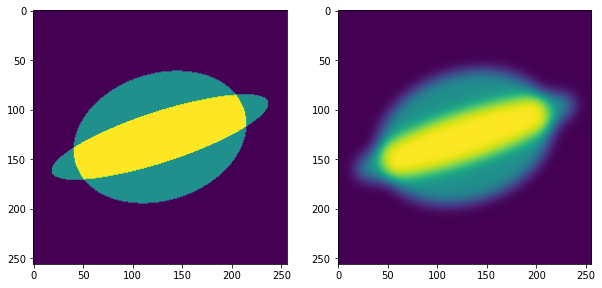

In [7]:
n = 256
N = n**2
Ncount = 1000
im,meas,Sigma = get_ellipse(n,Ncount=Ncount)
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im)
plt.subplot(122),plt.imshow(meas)

In [ ]:
t = np.linspace(500,2000,20)
a =[]
b =[]
D1 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-1,)),-1)
D1[0,-1] = -1
D2 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-n,)),n) - sp.sparse.diags(np.ones((n,)),n-N) 
for ti in range(20):
    #u_rec = l1solv(np.linalg.matrix_power(A.toarray(),int(t[ti])),meas1,constraint=False,epsilon=1e-1)
    u_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas.reshape(N,),constrain=False,rho=1,maxit=300,epsilon=1e7)
    #mix_norm = (np.linalg.norm(D1@(u_rec).reshape(N,), 0.5)+np.linalg.norm(D2@(u_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u_rec).reshape(N,), 2))**2
    mix_norm = (np.linalg.norm(D1@(u_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u_rec).reshape(N,), 2))**2 \
               + 1e-4*(np.linalg.norm(D2@(u_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(im.reshape(N,),u_rec)
    a.append(mix_norm)
    b.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 500.0 psnr 23.69496103004524 mixed norm: 2575.612180423554
N: 578.9473684210526 psnr 24.332875286838348 mixed norm: 2416.897714574418
N: 657.8947368421052 psnr 24.62804317442383 mixed norm: 2422.7989330082205
N: 736.8421052631579 psnr 24.024052915877032 mixed norm: 2397.272625535749
N: 815.7894736842105 psnr 23.98307188355492 mixed norm: 2095.359950958828
N: 894.7368421052631 psnr 25.135581966633858 mixed norm: 1907.9577187430855
N: 973.6842105263158 psnr 35.09915441518953 mixed norm: 1840.663544483983
N: 1052.6315789473683 psnr 32.40712652650185 mixed norm: 1994.7519411721664
N: 1131.578947368421 psnr 26.796645001543613 mixed norm: 2455.669606820654
N: 1210.5263157894738 psnr 22.87710716362408 mixed norm: 2913.0070384340256
N: 1289.4736842105262 psnr 19.373894568076796 mixed norm: 3434.9830449554456
N: 1368.421052631579 psnr 16.282496985901478 mixed norm: 3951.234585493391
N: 1447.3684210526317 psnr 13.50943165003823 mixed norm: 4476.90053670381
N: 1526.3157894736842 psnr 10.922118

([<matplotlib.lines.Line2D at 0x7f2e1f3fc250>],
 <matplotlib.legend.Legend at 0x7f2e1f3fc5d0>)

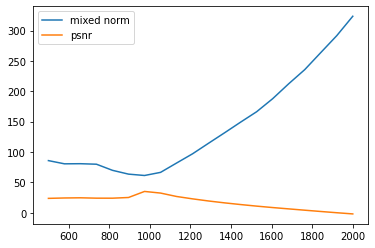

In [ ]:
plt.plot(t,np.array(a)/30)
plt.plot(t,b),plt.legend(['mixed norm','psnr'])

psnr 35.26001119588957


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2e1f39ee50>,
 Text(0.5, 1.0, 'measurement'))

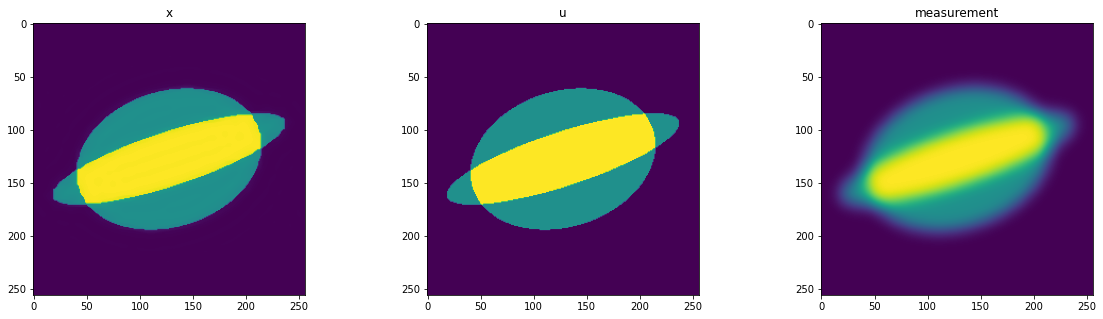

In [ ]:
N_recon = np.round(t[a==np.min(a)])
x,err,loss = myADMM(Sigma**int(N_recon),meas.reshape(N,1),constrain=False,rho=1,maxit=300,epsilon=1e7)
print('psnr',psnr2(x,im.reshape(N,)))
plt.figure(figsize=(20,5))
plt.subplot(131),plt.imshow(x.reshape(n,n)),plt.title('x')
plt.subplot(132),plt.imshow(im),plt.title('u')
#plt.subplot(143),plt.imshow(x_cvx.reshape(n,n)),plt.title('x_cvx')
plt.subplot(133),plt.imshow(meas),plt.title('measurement')

Moving average filter 

(<matplotlib.axes._subplots.AxesSubplot at 0x7f76eba8e510>,
 <matplotlib.image.AxesImage at 0x7f76eb944390>)

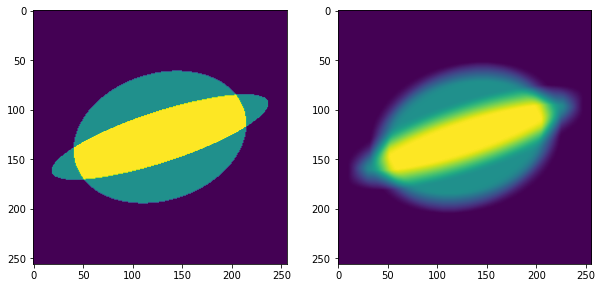

In [ ]:
im1,meas1,Sigma = get_ellipse(filter='average')
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im1)
plt.subplot(122),plt.imshow(meas1)

In [ ]:
t = np.linspace(800,1500,20)
a1 =[]
b1 =[]
for ti in range(20):
    u1_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas1.reshape(N,),constrain=False,rho=1,maxit=300,epsilon=1e2)
    mix_norm = (np.linalg.norm(D1@(u1_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u1_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u1_rec).reshape(N,), 2))**2 \
               + 1e-4*(np.linalg.norm(D2@(u1_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(im1.reshape(N,),u1_rec)
    a1.append(mix_norm)
    b1.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 800.0 psnr 23.40125138583319 mixed norm: 1856.154698337264
N: 836.8421052631579 psnr 23.935110018335156 mixed norm: 1855.785560287412
N: 873.6842105263158 psnr 24.472522938695562 mixed norm: 1869.9547673602572
N: 910.5263157894738 psnr 25.032660438711535 mixed norm: 1865.624613325639
N: 947.3684210526316 psnr 25.4258239789398 mixed norm: 1875.7737004890373
N: 984.2105263157895 psnr 25.4963909376361 mixed norm: 1876.421362819784
N: 1021.0526315789474 psnr 25.24634261508448 mixed norm: 1876.3902397336792
N: 1057.8947368421052 psnr 24.892775145256408 mixed norm: 1902.6626186556173
N: 1094.7368421052631 psnr 24.415869929537827 mixed norm: 1892.869810640613
N: 1131.578947368421 psnr 24.06043080111685 mixed norm: 1904.0504526374732
N: 1168.421052631579 psnr 23.723887319124188 mixed norm: 1936.165362858573
N: 1205.2631578947369 psnr 23.391799511004166 mixed norm: 1956.2754271527635
N: 1242.1052631578948 psnr 23.079352311495665 mixed norm: 1963.5241018701101
N: 1278.9473684210527 psnr 22.78

([<matplotlib.lines.Line2D at 0x7f76eb8f2cd0>],
 <matplotlib.legend.Legend at 0x7f76eb944790>)

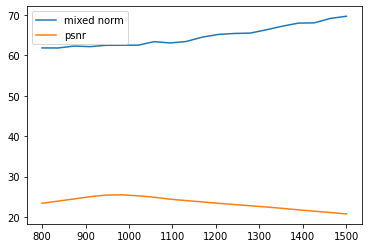

In [ ]:
plt.plot(t,np.array(a1)/30)
plt.plot(t,b1),plt.legend(['mixed norm','psnr'])

psnr of reconstruction 23.949460308298935
psnr of measurement 22.316003391039445


(<matplotlib.axes._subplots.AxesSubplot at 0x7f76eb817f90>,
 Text(0.5, 1.0, 'measurement'))

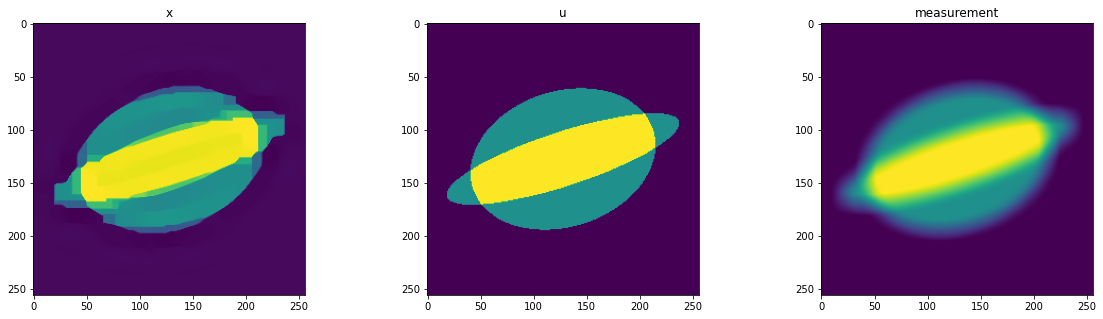

In [ ]:
N_recon = np.round(t[a1==np.min(a1)])
x1,err,loss = myADMM(Sigma**int(N_recon),meas1.reshape(N,1),constrain=False,rho=1,maxit=300,epsilon=1e2)
print('psnr of reconstruction',psnr2(im1.reshape(N,),x1))
print('psnr of measurement',psnr2(im1.reshape(N,),meas1.reshape(N,)))
plt.figure(figsize=(20,5))
plt.subplot(131),plt.imshow(x1.reshape(n,n)),plt.title('x')
plt.subplot(132),plt.imshow(im),plt.title('u')
plt.subplot(133),plt.imshow(meas1),plt.title('measurement')

Maximum filter (indeed, there's no diffusion for the maximum filter, it makes sense that the method doesn't work for this case)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f76eb83ce50>,
 <matplotlib.image.AxesImage at 0x7f76eb6c2ed0>)

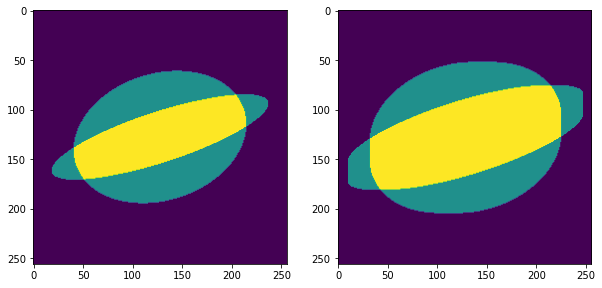

In [ ]:
im2,meas2,Sigma = get_ellipse(filter='maximum')
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im2)
plt.subplot(122),plt.imshow(meas2)

In [ ]:
t = np.linspace(8,1500,20)
a2 =[]
b2 =[]
for ti in range(20):
    u2_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas2.reshape(N,),constrain=False,rho=1,maxit=300,epsilon=1e0)
    mix_norm = (np.linalg.norm(D1@(u2_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u2_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u2_rec).reshape(N,), 2))**2 \
               + 1e-4*(np.linalg.norm(D2@(u2_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(im2.reshape(N,),u2_rec)
    a2.append(mix_norm)
    b2.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 8.0 psnr 13.173134105865143 mixed norm: 1808.1213041842107
N: 86.52631578947368 psnr 13.112038228008734 mixed norm: 1679.9059711495513
N: 165.05263157894737 psnr 13.068824587200451 mixed norm: 1613.2958135452195
N: 243.57894736842104 psnr 13.024416298174907 mixed norm: 1557.1289921594353
N: 322.10526315789474 psnr 12.98347622010792 mixed norm: 1491.9807158083036
N: 400.63157894736844 psnr 12.950311685631464 mixed norm: 1447.3307907119736
N: 479.1578947368421 psnr 12.917563471088402 mixed norm: 1400.3003384733568
N: 557.6842105263158 psnr 12.893418267890393 mixed norm: 1385.243491952261
N: 636.2105263157895 psnr 12.86547574615215 mixed norm: 1349.638394065536
N: 714.7368421052631 psnr 12.840968812135586 mixed norm: 1328.8284732824636
N: 793.2631578947369 psnr 12.82132863430408 mixed norm: 1320.1206711780644
N: 871.7894736842105 psnr 12.806781184882233 mixed norm: 1316.7318761959032
N: 950.3157894736842 psnr 12.791152383182649 mixed norm: 1298.0340870481455
N: 1028.842105263158 psnr 1

([<matplotlib.lines.Line2D at 0x7f76eb6a3c10>],
 <matplotlib.legend.Legend at 0x7f76eb8403d0>)

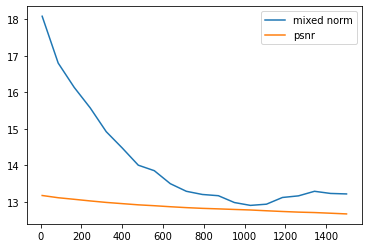

In [ ]:
plt.plot(t,np.array(a2)/100)
plt.plot(t,b2),plt.legend(['mixed norm','psnr'])

psnr of reconstruction 13.169086090870353
psnr of measurement 12.823268564386366


(<matplotlib.axes._subplots.AxesSubplot at 0x7f76eb591ad0>,
 Text(0.5, 1.0, 'measurement'))

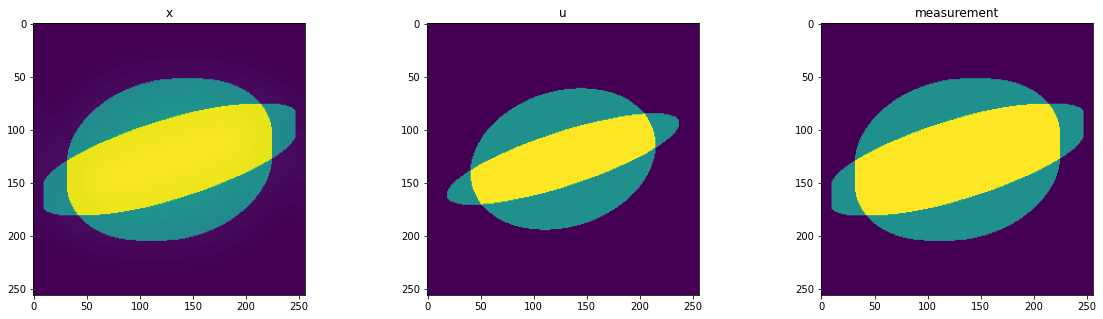

In [ ]:
N_recon = 10#np.round(t[a==np.min(a)])
x2,err,loss = myADMM(Sigma**int(N_recon),meas2.reshape(N,1),constrain=False,rho=1,maxit=300,epsilon=1e0)
#x2 = np.minimum(x2,1)
print('psnr of reconstruction',psnr2(im2.reshape(N,),x2))
print('psnr of measurement',psnr2(im2.reshape(N,),meas2.reshape(N,)))
plt.figure(figsize=(20,5))
plt.subplot(131),plt.imshow(x2.reshape(n,n),vmax=1),plt.title('x')
plt.subplot(132),plt.imshow(im,vmax=1),plt.title('u')
plt.subplot(133),plt.imshow(meas2,vmax=1),plt.title('measurement')

Pyramid filter


(<matplotlib.axes._subplots.AxesSubplot at 0x7efd195fd750>,
 <matplotlib.image.AxesImage at 0x7efd1945a8d0>)

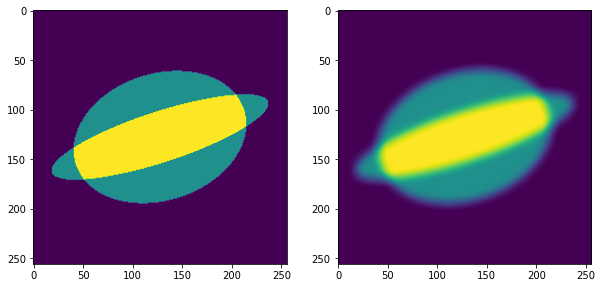

In [24]:
im3,meas3,Sigma = get_ellipse(filter='pyramid')
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im3)
plt.subplot(122),plt.imshow(meas3)

In [30]:
lf=100
for j in range(1000):   
    Fl=obj(lf,meas3)
    lf2=max(int(lf+50*np.random.randn()),0)
    Fl2=obj(lf2,meas3)
    print(lf,lf2,Fl/Fl2)
    if ((Fl/Fl2)>np.random.uniform(0.98,1)):
        lf=lf2
    else:
        lf=lf

100 73 0.9461972175321222
100 142 1.0658348320202968
142 189 1.1092515314373403
189 251 1.0644105186815223
251 210 0.9652359797564338
251 220 0.9795879209528734
251 246 1.001582917057427
246 192 0.9440014206761215
246 215 0.9711001554035715
246 289 0.9810193776718233
246 255 0.9978439733054129
255 308 0.9817602328057222
255 211 0.9674520376366849
255 170 0.8794464562270372
255 234 0.9968877060356821
234 197 0.9559041097384923
234 228 0.9936315527898887
228 317 0.9808799893046654
228 274 1.0028829951574532
274 223 0.9902536201512261
223 266 1.0126395109275719
266 268 0.9999010623552104
268 174 0.8989530821516127
268 383 0.9968277577100669
268 237 1.0024256459485612
237 350 0.9906952434426872
237 284 0.9880182784402374
237 316 0.9742158455475806
237 307 0.9836742314075598
237 289 0.9846515282545701
237 247 1.0045191083936273
247 216 0.9715271479940275
247 253 0.9980023120743703
253 289 0.9821838966029574
253 248 1.0016313595360273
248 170 0.877161077133229
248 334 0.9733375424814207
248 

KeyboardInterrupt: ignored

In [ ]:
t = np.linspace(100,1000,20)
a3 =[]
b3 =[]
D1 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-1,)),-1)
D1[0,-1] = -1
D2 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-n,)),n) - sp.sparse.diags(np.ones((n,)),n-N) 
for ti in range(20):
    u3_rec,err,loss = myADMM(Sigma**(int(t[ti])),meas3.reshape(N,),constrain=False,rho=1,maxit=300,epsilon=1e2)
    mix_norm = (np.linalg.norm(D1@(u3_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u3_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u3_rec).reshape(N,), 2))**2 \
               + 1e-4*(np.linalg.norm(D2@(u3_rec).reshape(N,), 2))**2
    #mix_norm = np.linalg.norm(((D1@(u3_rec)).reshape(N,)**2+(D2@(u3_rec)).reshape(N,)**2)**0.5,0.5)**0.5 + 1e-4*(np.linalg.norm(D1@(u3_rec).reshape(N,), 2))**2 \
    #           + 1e-4*(np.linalg.norm(D2@(u3_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(im3.reshape(N,),u3_rec)
    a3.append(mix_norm)
    b3.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 100.0 psnr 24.450119117622584 mixed norm: 2033.7444403230309
N: 147.3684210526316 psnr 24.20308101384541 mixed norm: 1945.5540207952806
N: 194.73684210526318 psnr 23.45878468187963 mixed norm: 1704.462695110764
N: 242.10526315789474 psnr 23.644868349628748 mixed norm: 1613.5675674179013
N: 289.47368421052636 psnr 24.33308806642359 mixed norm: 1644.7619897629013
N: 336.8421052631579 psnr 25.294424684097642 mixed norm: 1652.348262621943
N: 384.2105263157895 psnr 26.539472036693972 mixed norm: 1627.9476697848636
N: 431.5789473684211 psnr 26.991601129227462 mixed norm: 1477.0560044576282
N: 478.94736842105266 psnr 26.60419586799185 mixed norm: 1594.8878610867714
N: 526.3157894736842 psnr 26.069568077018626 mixed norm: 1758.076602063561
N: 573.6842105263158 psnr 25.32145684227253 mixed norm: 1779.0700296019438
N: 621.0526315789474 psnr 24.697853197337455 mixed norm: 1794.8833414622898
N: 668.421052631579 psnr 24.120907714810944 mixed norm: 1845.533898341866
N: 715.7894736842105 psnr 23.5

([<matplotlib.lines.Line2D at 0x7f2e1e99a7d0>],
 <matplotlib.legend.Legend at 0x7f2e1e9b2a90>)

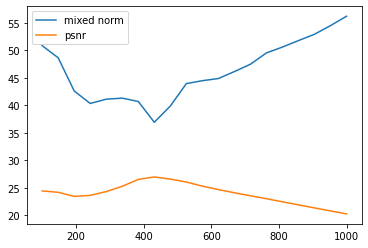

In [ ]:
plt.plot(t,np.array(a3)/40)
plt.plot(t,b3),plt.legend(['mixed norm','psnr'])

psnr of reconstruction 27.0000186692084
psnr of measurement 23.97272875295428


(<matplotlib.axes._subplots.AxesSubplot at 0x7efd19328690>,
 Text(0.5, 1.0, 'error map'))

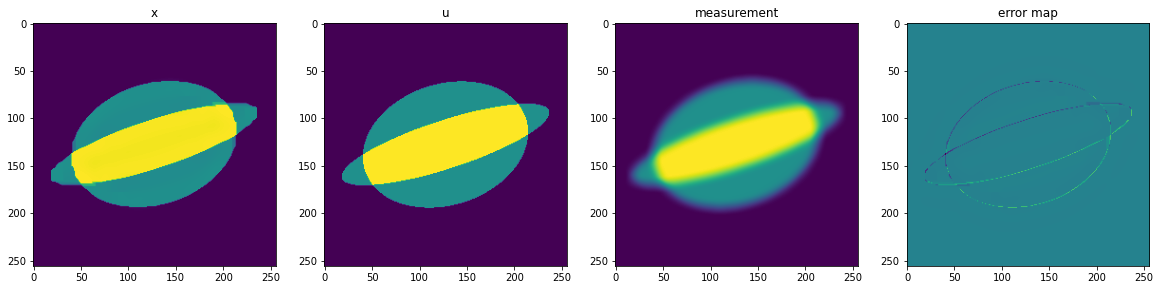

In [26]:
N_recon = lf#np.round(t[a3==np.min(a3)])
x3,err,loss = myADMM(Sigma**int(N_recon),meas3.reshape(N,1),constrain=True,rho=1,maxit=300,epsilon=1e2)
#x2 = np.minimum(x2,1)
print('psnr of reconstruction',psnr2(im3.reshape(N,),x3))
print('psnr of measurement',psnr2(im3.reshape(N,),meas3.reshape(N,)))
plt.figure(figsize=(20,5))
plt.subplot(141),plt.imshow(x3.reshape(n,n)),plt.title('x')
plt.subplot(142),plt.imshow(im3,vmax=1),plt.title('u')
plt.subplot(143),plt.imshow(meas3,vmax=1),plt.title('measurement')
plt.subplot(144),plt.imshow(im3-x3.reshape(n,n),vmax=1),plt.title('error map')

Gaussian local


(<matplotlib.axes._subplots.AxesSubplot at 0x7f9ba1fd2610>,
 <matplotlib.image.AxesImage at 0x7f9ba1a939d0>)

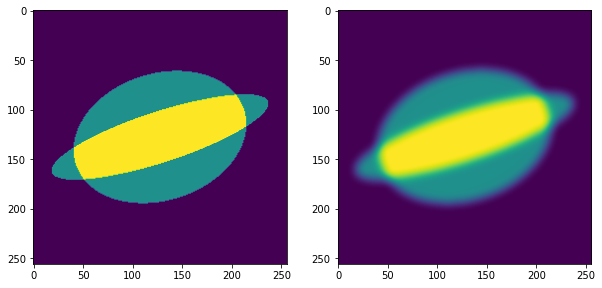

In [8]:
im4,meas4,Sigma = get_ellipse(filter='Gaussian_local')
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im4)
plt.subplot(122),plt.imshow(meas4,vmax=1)

In [22]:
lf=100
for j in range(1000):   
    Fl=obj(lf,meas4)
    lf2=max(int(lf+100*np.random.randn()),0)
    Fl2=obj(lf2,meas4)
    print(lf,lf2,Fl/Fl2)
    if ((Fl/Fl2)>np.random.uniform(0.98,1)):
        lf=lf2
    else:
        lf=lf

100 129 1.1480198963274677
129 205 1.0777643809168553
205 79 0.825823801725795
205 95 0.7926779371151546
205 99 0.8027880494280301
205 265 1.0902037781015217
265 277 0.9988126149308396
277 104 0.7693276922176457
277 193 0.883460482497341
277 419 1.2373752612459403
419 398 0.9104982210460887
419 341 0.7413339849900927
419 516 0.7885080852100604
419 478 0.8731894902678651
419 466 0.9110853506274487
419 393 0.8898018752599337
419 403 0.9347889598646848
419 490 0.8422099744012075
419 453 0.9607555877353877
419 461 0.9295288908973371
419 362 0.7759262766151342
419 444 0.9988294851008167
444 324 0.7730759292650157
444 576 0.7584541291072963
444 454 0.9575921534917449
444 601 0.75142898388941
444 365 0.7852306169008237
444 448 0.9832410763535254
448 597 0.7666863711994052
448 379 0.8459315109582682
448 757 0.7119397364797596
448 485 0.8704362803908307
448 460 0.9500828355464467
448 407 0.9712817094975722
448 177 0.650682037427538
448 327 0.7784869039105338
448 490 0.8575688803808448
448 246 0

KeyboardInterrupt: ignored

psnr of reconstruction 26.46393687541717
psnr of measurement 24.004762666644226


(<matplotlib.axes._subplots.AxesSubplot at 0x7f9b9903dc90>,
 Text(0.5, 1.0, 'error map'))

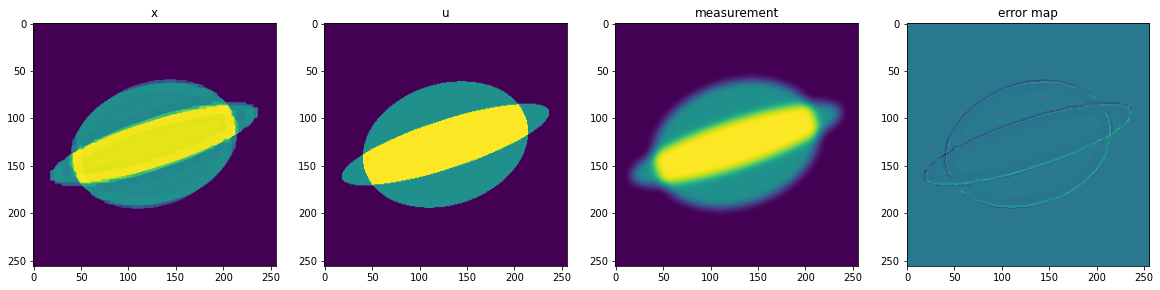

In [10]:
N_recon = 431#np.round(t[a4==np.min(a4)])
x4,err,loss = myADMM(Sigma**int(N_recon),meas4.reshape(N,1),constrain=True,rho=1,maxit=300,epsilon=1e4)
#x2 = np.minimum(x2,1)
print('psnr of reconstruction',psnr2(im4.reshape(N,),x4))
print('psnr of measurement',psnr2(im4.reshape(N,),meas4.reshape(N,)))
plt.figure(figsize=(20,5))
plt.subplot(141),plt.imshow(x4.reshape(n,n)),plt.title('x')
plt.subplot(142),plt.imshow(im4,vmax=1),plt.title('u')
plt.subplot(143),plt.imshow(meas4),plt.title('measurement')
plt.subplot(144),plt.imshow(im4-x4.reshape(n,n),vmax=1),plt.title('error map')

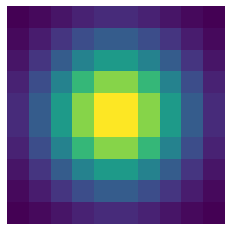

In [ ]:
 ##Creating a Gaussian kernel
# Initializing value of x-axis and y-axis
# in the range -1 to 1
x1, y1 = np.meshgrid(np.linspace(-1,1,10), np.linspace(-1,1,10))
dst = np.sqrt((x1*x1+y1*y1))
  
# Intializing sigma and muu
sigma = 0.5
muu = 0.000
  
# Calculating Gaussian array
gauss = np.exp(-( (dst-muu)**2 / ( 2.0 * sigma**2 ) ) )
plt.imshow(gauss)
plt.axis('off')
plt.show()

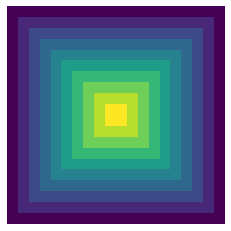

In [ ]:
size = 20
P = pyramid(size)
plt.imshow(P)
plt.axis('off')
plt.show()

In [ ]:

fig, ax = plt.subplots(2,4,figsize=(16,8), constrained_layout=True)
i0=ax[0,0].imshow(gauss/np.linalg.norm(gauss,1))
ax[0,0].set_ylabel('Gaussian blurring')
ax[0,0].axis('off')

ax[0,0].set_title(' Gaussian Kernel',fontsize=19)
i1=ax[0,1].imshow(meas,vmax=1)
ax[0,1].axis('off')
ax[0,1].set_title('Gaussian blurring \n PSNR=22.14dB',fontsize=19)
i2=ax[0,2].imshow(x.reshape(n,n))
ax[0,2].axis('off')
ax[0,2].set_title('Reconstruction \n PSNR=35dB',fontsize=19)
i3=ax[0,3].imshow(np.abs(im-x.reshape(n,n)),vmax=1)
ax[0,3].set_title('Absolute error',fontsize=19)
ax[0,3].axis('off')

i4=ax[1,0].imshow(P/np.linalg.norm(P,1))
ax[1,0].axis('off')
ax[1,0].set_title('Pyramid kernel',fontsize=19)
i5=ax[1,1].imshow(meas,vmax=1)
ax[1,1].set_title('Pyramid blurring \n PSNR=23.97dB',fontsize=19)
ax[1,1].axis('off')
i6=ax[1,2].imshow(x3.reshape(n,n))
ax[1,2].set_title('Reconstruction \n PSNR=27dB',fontsize=19)
ax[1,2].axis('off')
i7=ax[1,3].imshow(np.abs(im3-x3.reshape(n,n)),vmax=1)
ax[1,3].set_title('Absolute error',fontsize=19)
ax[1,3].axis('off')
cbar0 = fig.colorbar(i0, ax=ax[:, 0], shrink=0.8,aspect=50)
cbar = fig.colorbar(i1, ax=ax[:, 1:3], shrink=0.8,aspect=50)
cbar1 = fig.colorbar(i3, ax=ax[:,3], shrink=0.8,aspect=50)
plt.savefig('figures/2D.svg', format='svg')
plt.show()       

NameError: ignored

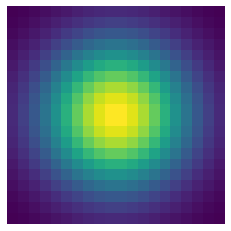

In [27]:
 ##Creating a Gaussian kernel
# Initializing value of x-axis and y-axis
# in the range -1 to 1
x1, y1 = np.meshgrid(np.linspace(-1,1,20), np.linspace(-1,1,20))
dst = np.sqrt((x1*x1+y1*y1))
  
# Intializing sigma and muu
sigma = 0.5
muu = 0.000
  
# Calculating Gaussian array
gauss = np.exp(-( (dst-muu)**2 / ( 2.0 * sigma**2 ) ) )
gauss = gauss/np.sum(gauss)
plt.imshow(gauss)
plt.axis('off')
plt.show()

P = pyramid(20)
P = P/np.sum(P)

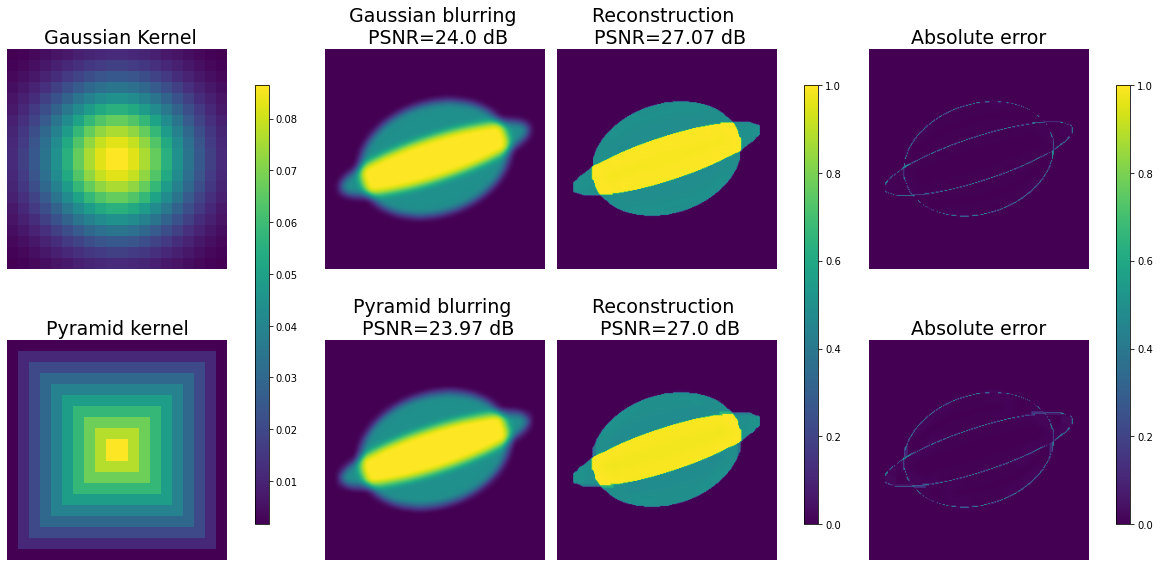

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
fig, ax = plt.subplots(2,4,figsize=(16,8), constrained_layout=True)
i0=ax[0,0].imshow(gauss/np.linalg.norm(gauss,1))
ax[0,0].set_ylabel('Gaussian blurring')
ax[0,0].axis('off')

ax[0,0].set_title(' Gaussian Kernel',fontsize=19)
i1=ax[0,1].imshow(meas4,vmax=1)
ax[0,1].axis('off')
ax[0,1].set_title('Gaussian blurring \n PSNR=%s dB' %str(round(psnr2(im.reshape(N,),meas4.reshape(N,)),2)),fontsize=19)
i2=ax[0,2].imshow(x4.reshape(n,n))
ax[0,2].axis('off')
ax[0,2].set_title('Reconstruction \n PSNR=%s dB' %str(round(psnr2(im.reshape(N,),x4),2)),fontsize=19)
i3=ax[0,3].imshow(np.abs(im4-x4.reshape(n,n)),vmax=1)
ax[0,3].set_title('Absolute error',fontsize=19)
ax[0,3].axis('off')

i4=ax[1,0].imshow(P/np.linalg.norm(P,1))
ax[1,0].axis('off')
ax[1,0].set_title('Pyramid kernel',fontsize=19)
i5=ax[1,1].imshow(meas3,vmax=1)
ax[1,1].set_title('Pyramid blurring \n PSNR=%s dB' %str(round(psnr2(im.reshape(N,),meas3.reshape(N,)),2)),fontsize=19)
ax[1,1].axis('off')
i6=ax[1,2].imshow(x3.reshape(n,n))
ax[1,2].set_title('Reconstruction \n PSNR=%s dB' %str(round(psnr2(im.reshape(N,),x3),2)),fontsize=19)
ax[1,2].axis('off')
i7=ax[1,3].imshow(np.abs(im3-x3.reshape(n,n)),vmax=1)
ax[1,3].set_title('Absolute error',fontsize=19)
ax[1,3].axis('off')
cbar0 = fig.colorbar(i0, ax=ax[:, 0], shrink=0.8,aspect=50)
cbar = fig.colorbar(i1, ax=ax[:, 1:3], shrink=0.8,aspect=50)
cbar1 = fig.colorbar(i3, ax=ax[:,3], shrink=0.8,aspect=50)
plt.savefig('2DTV1.svg', format='svg')
plt.show()       
files.download("2DTV1.svg") 

In [ ]:
t = np.linspace(100,1000,20)
a3 =[]
b3 =[]
D1 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-1,)),-1)
D1[0,-1] = -1
D2 = sp.sparse.diags(np.ones((N,)),0) - sp.sparse.diags(np.ones((N-n,)),n) - sp.sparse.diags(np.ones((n,)),n-N) 
T = 100
Nhat3 = 100
N_best3 = Nhat3
mydict = {}
mydict[int(Nhat3)] = 0
u3_rec,err,loss = myADMM(Sigma**(int(Nhat)),meas3.reshape(N,),constrain=True,rho=1,maxit=300,epsilon=1e2)
hp = (np.linalg.norm(D1@(u3_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u3_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u3_rec).reshape(N,), 2))**2 \
               + 1e-4*(np.linalg.norm(D2@(u3_rec).reshape(N,), 2))**2
h_best=hp
print('iteration',0,'N:',Nhat3,'loss:',hp)
for i in range(T):
  Nc = max(int(Nhat3 + 50*np.random.randn()),0)
  mydict[int(Nc)] = 0
  u3_rec,err,loss = myADMM(Sigma**(int(Nc)),meas3.reshape(N,),constrain=True,rho=1,maxit=300,epsilon=1e2)
  hc = (np.linalg.norm(D1@(u3_rec).reshape(N,), 0.5)**0.5+np.linalg.norm(D2@(u3_rec).reshape(N,), 0.5))**0.5 + 1e-4*(np.linalg.norm(D1@(u3_rec).reshape(N,), 2))**2 \
               + 1e-4*(np.linalg.norm(D2@(u3_rec).reshape(N,), 2))**2
  if hc < h_best:
    h_best = hc
    N_best3 = Nc
  else:
    mydict[int(N_best3)] += 1
    if mydict[int(N_best3)] > 15:
      print('converges at %d' % int(N_best3))
      break 
  if hc < hp:
    Nhat3 = Nc
    hp = hc
  else:
    if np.random.rand() > 0.9:
      Nhat3 = Nc
      hp = hc
  print('iteration',i+1,'N:',Nhat3,'loss:',hp,'Nbest:',N_best3)